In [1]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrdata.utils.bbox_utils import scale_XYWH_box
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [10]:
# Render and visualize a scan

SCAN = "KAMX20101024_111513_V03"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"
    # /scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/2010/10/22/KAMX/KAMX20101022_105646_V03.gz
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

radar = pyart.io.read_nexrad_archive(SCAN_FILE)
data, fields, elevs, y, x = radar2mat(radar,
                                      fields=ATTRIBUTES,
                                      coords='cartesian',
                                      r_max=150000,
                                      dim=600,
                                      elevs=ELEVATIONS)
with open("try.npy", "wb") as f: np.save(f, data.reshape((-1)))

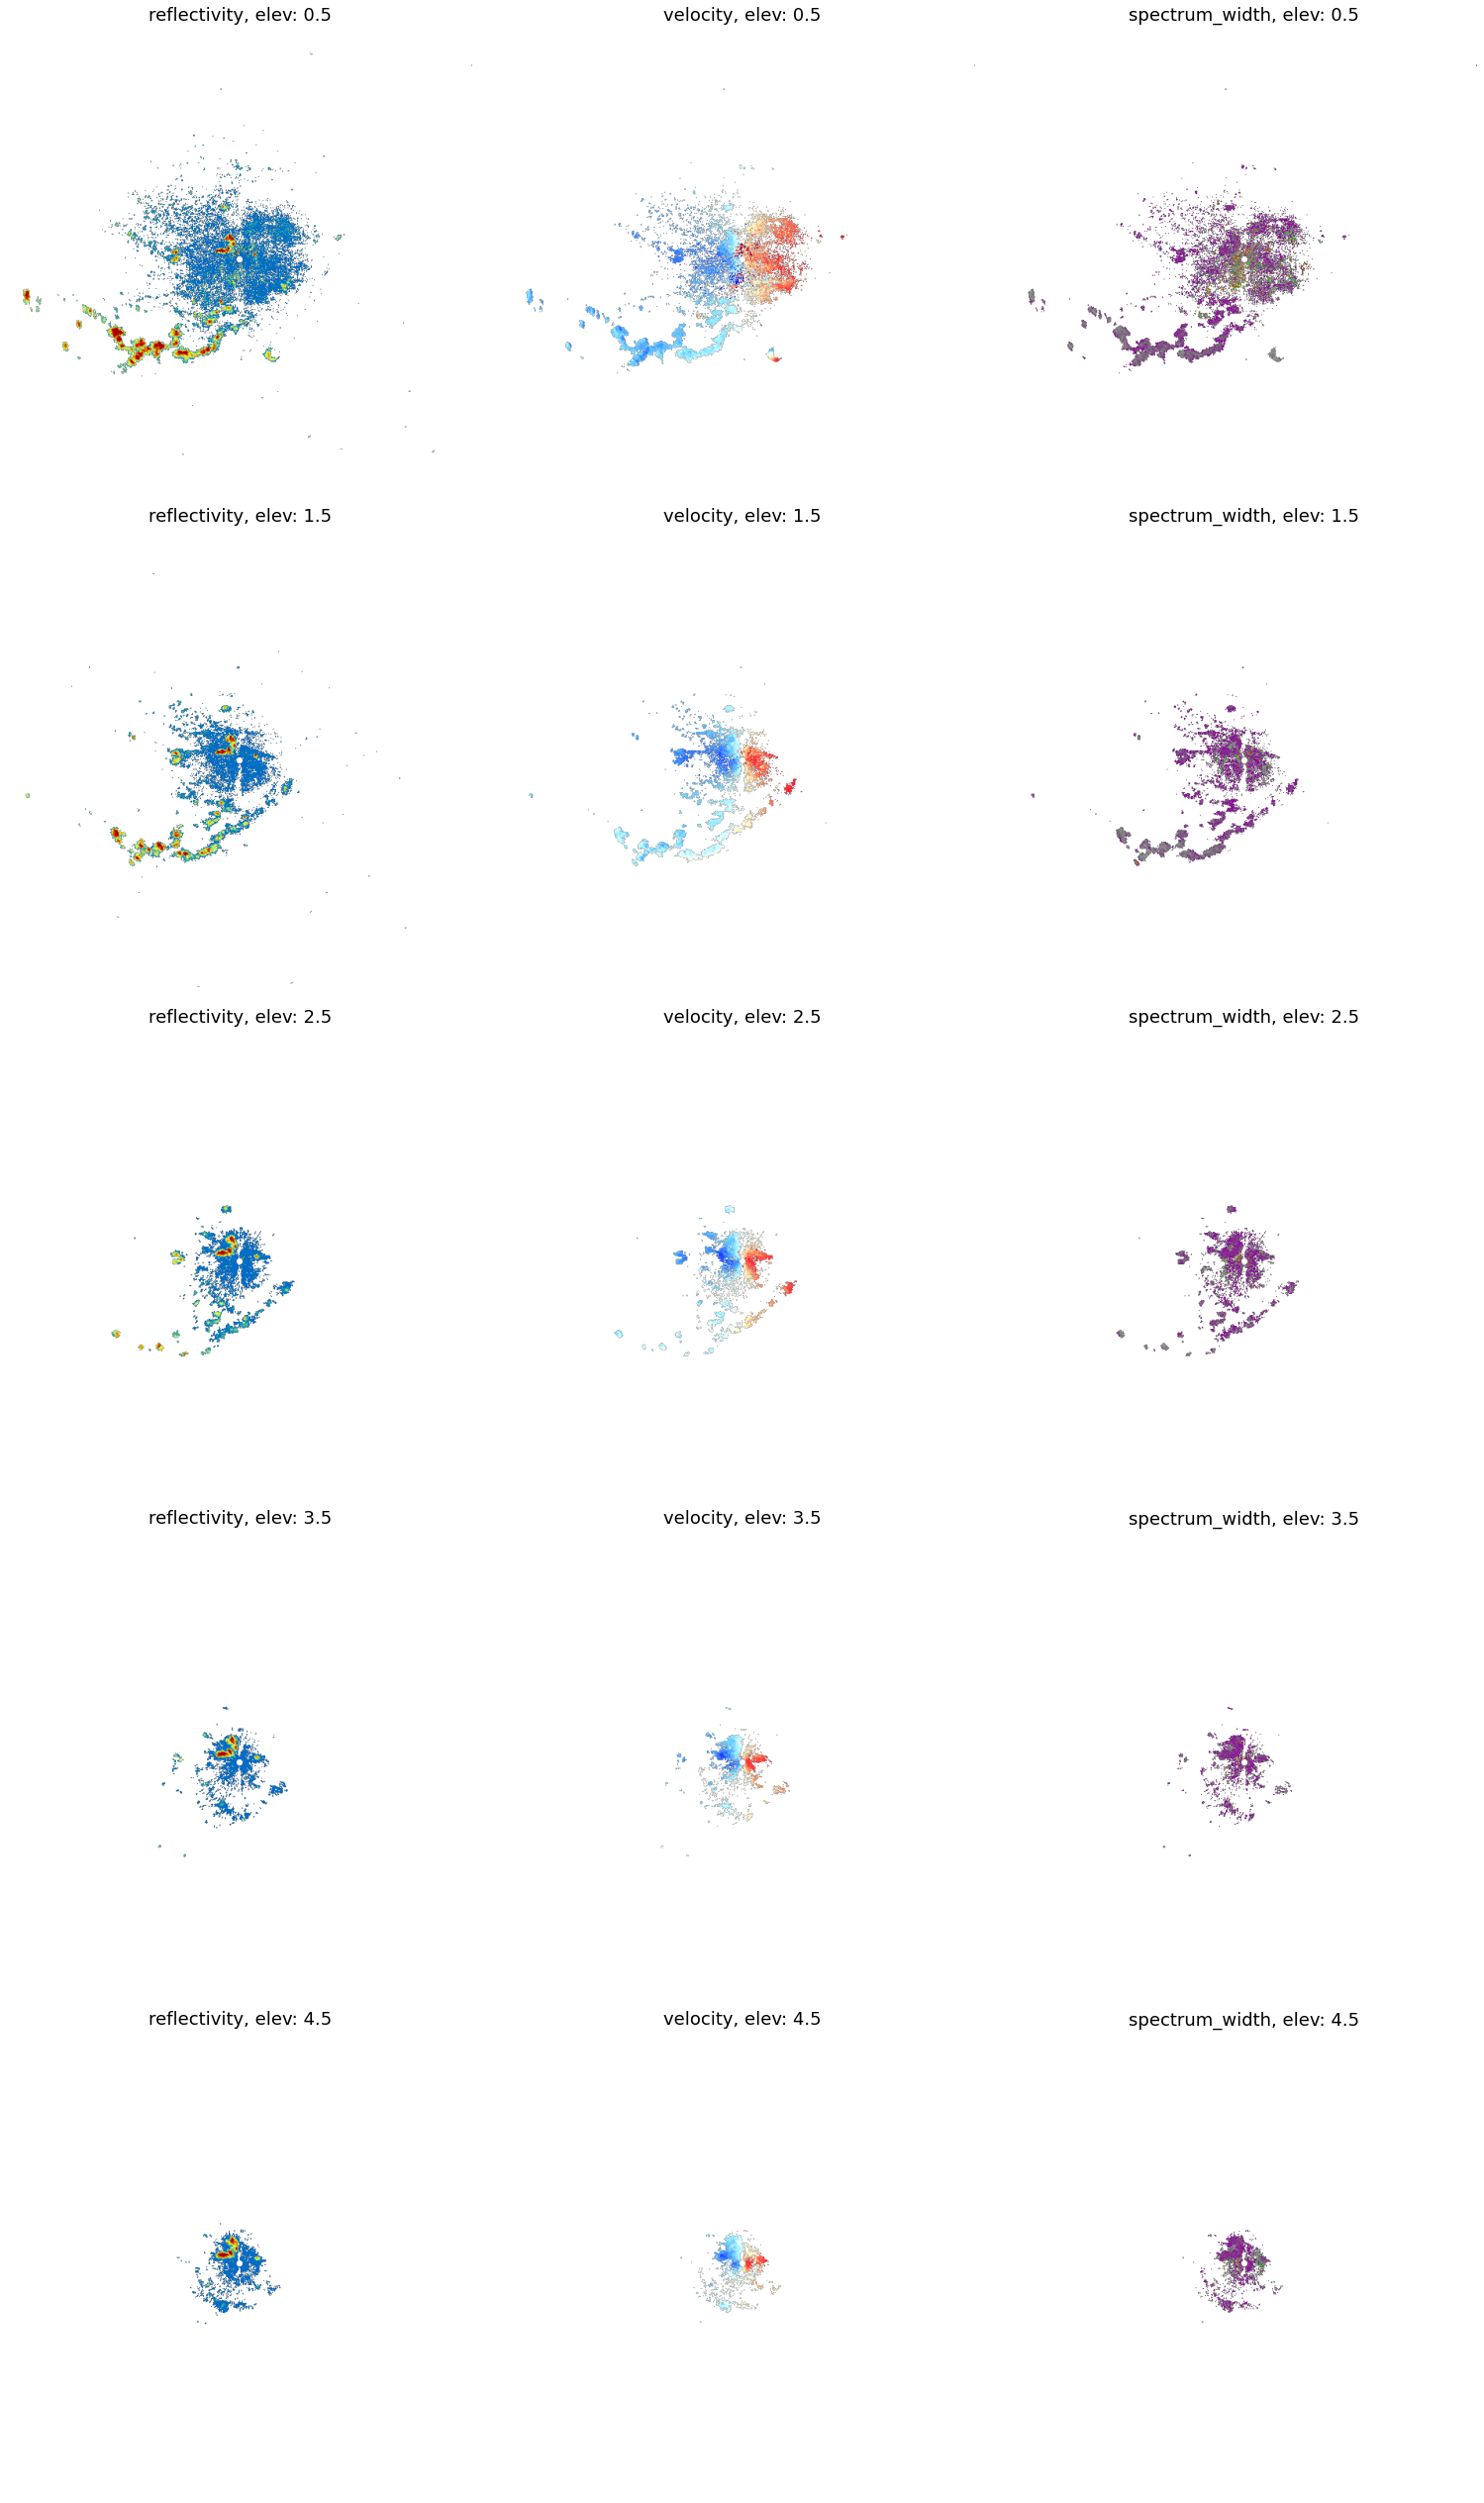

In [4]:
# Render and visualize a scan

SCAN = "KAMX20101024_111513_V03"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"
    # /scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/2010/10/22/KAMX/KAMX20101022_105646_V03.gz
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

radar = pyart.io.read_nexrad_archive(SCAN_FILE)
data, fields, elevs, y, x = radar2mat(radar,
                                      as_dict=True,
                                      fields=ATTRIBUTES,
                                      coords='cartesian',
                                      r_max=150000,
                                      dim=600,
                                      elevs=ELEVATIONS)
for f in data: data[f] = np.flip(data[f], 2)

fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES), figsize=(21, 35), constrained_layout=True)
# fig.tight_layout()
for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        subplt = axs[j, i]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](data[attr][j, :, :]))
        subplt.imshow(rgb)

plt.show()

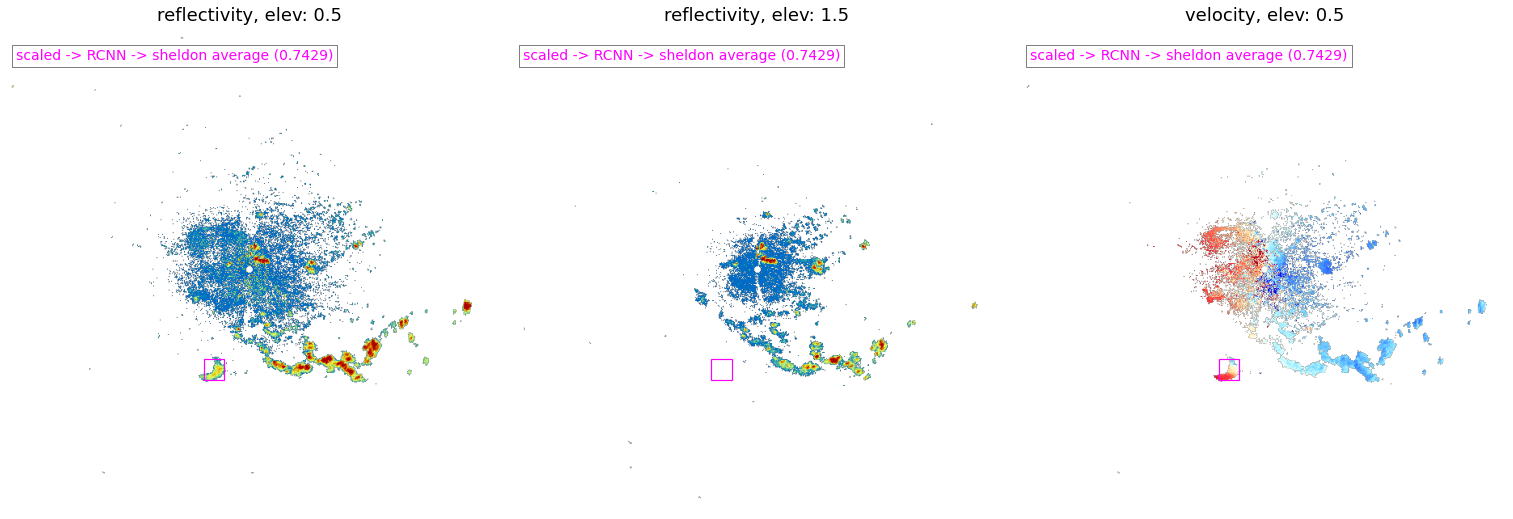

In [5]:
# Visualize an npy array with annotations from json

# define which scan to visualize, which json to be the source of annotations
SCAN = "KAMX20101024_112106_V03"
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts-v0.1.0-official/roosts-v0.1.0.json"
OUTPUT_DIR = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts-v0.1.0-official/visualization"

# colors for bboxes
color_array = [
    '#006400', # for not scaled boxes
    '#FF00FF', # scaled to RCNN then to user factor 0.7429 which is sheldon average
    '#800080',
    '#FFA500',
    '#FFFF00'
]

with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
scan_to_id = {}
for split in dataset["scans"]:
    for scan in dataset["scans"][split]:
        scan_to_id[scan["scan"]] = (split, scan["scan_id"])
scan = dataset["scans"][scan_to_id[SCAN][0]][scan_to_id[SCAN][1]]

array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))
array_channel_indices = dataset["info"]["array_channel_indices"]

fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
for i, (attr, elev) in enumerate([("reflectivity", "0.5"), ("reflectivity", "1.5"), ("velocity", "0.5")]):
    subplt = axs[i]
    subplt.axis('off')
    subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
    cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
    rgb = cm(NORMALIZERS[attr](array[array_channel_indices[attr][elev], :, :]))
    subplt.imshow(rgb)
    for annotation in scan["annotations"]:
        bbox = annotation["bbox"]
#         uncomment the following lines if the input bboxes contain annotator biases
#         subplt.add_patch(
#             plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
#                           fill=False,
#                           edgecolor=color_array[0], 
#                           linewidth=1.2)
#         )
#         subplt.text(10, 10, 'not scaled', 
#                     bbox=dict(facecolor='white', alpha=0.5),fontsize=14, color=color_array[0])
        
#         bbox = scale_XYWH_box(bbox, dataset["info"]["bbox_scaling_factors"][annotation["bbox_annotator"]])
        subplt.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                          fill=False,
                          edgecolor=color_array[1], 
                          linewidth=1.2)
        )
        subplt.text(10, 40, 'scaled -> RCNN -> sheldon average (0.7429)', 
                    bbox=dict(facecolor='white', alpha=0.5),fontsize=14, color=color_array[1])

plt.show()


if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
fig.savefig(os.path.join(OUTPUT_DIR, SCAN+".png"), bbox_inches = "tight")
plt.close(fig)